<a href="https://colab.research.google.com/github/usmanqadeer1/PSGD/blob/master/PSGD_MNIST_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SET UP

In [0]:
# !kill -9 -1
import tensorflow as tf
# tf.test.gpu_device_name()
print(tf.__version__)
import matplotlib.pyplot as plt
import numpy as np
import time
import math

from tabulate import tabulate
import scipy.io
from sklearn import metrics

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
%load_ext tensorboard

2.2.0-rc3
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
from google.colab import drive
from google.colab import files
import sys

drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/'
results_dir = base_dir + 'results1/'
logs_dir = base_dir + 'log'
sys.path.append(base_dir)
import preconditioned_stochastic_gradient_descent as psgd 

Mounted at /content/gdrive/
Mounted at /content/gdrive/


#Defining Functions

In [0]:
def plot_metrics(xaxis,yaxis,title, x_label,y_label):
  fig = plt.figure(figsize=(15,10))
  if(xaxis != None):
    for opt in opts:
      plt.semilogy(xaxis[opt],yaxis[opt])
  else:
    for opt in opts:
      plt.semilogy(yaxis[opt])

  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend(opts)

# Set up for MNIST classification CNN

## Download MNIST Data

In [0]:
"""MNIST, classification"""
np.random.seed(0)

# Parameter Settings
batch_size = 128
num_f = 32  # number of features 
ITERATIONS = 20000
GAP = 100

dtype = tf.float32

mnist = tf.keras.datasets.mnist.load_data()

In [0]:
(mnist_train_data, mnist_train_labels), (mnist_test_data, mnist_test_labels) = mnist

print('total images:',mnist_train_data.shape[0])
print('training images:',mnist_train_data.shape[0])
print('test images:',mnist_test_data.shape[0])
print('number of features:',mnist_train_data.shape[1])


# reshape data as 28x28x1 image 
train_data = np.reshape(2.0*mnist_train_data - 1.0, [60000, 28, 28, 1])

#binarize the labels
train_label = tf.keras.utils.to_categorical(mnist_train_labels)
test_label = tf.keras.utils.to_categorical(mnist_test_labels)

total images: 60000
training images: 60000
test images: 10000
number of features: 28


In [0]:
def get_batches():
    # generate 60000 numbers randomly without replacement
    rp = np.random.permutation(train_data.shape[0])
    x = -np.ones([batch_size, 32, 32, 1])
    
    # augumentation: randomly shifting image by +-2 pixels 
    for i in range(batch_size):
        m = math.floor(5.0*np.random.rand())
        n = math.floor(5.0*np.random.rand())
        x[i, m:m+28, n:n+28] = train_data[rp[i]]
    y = train_label[rp[0:batch_size]]
    return x, y

## Defining CNN model for training.
The model consists of 2 convolutional layers, 1 avgpool layer, 2 convolutional layers, 1 avg pool layer, 1 FC layer, 1 FC layer.

In [0]:
train_inputs = tf.placeholder(dtype, [batch_size, 32, 32, 1])
train_outputs = tf.placeholder(dtype, [batch_size, 10])
adam_step = tf.placeholder(tf.float32, shape = ())

In [0]:
# (hight, width, in_ch, out_ch) tensor --> (hight * width * in_ch, out_ch) matrix 
W1 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*1+1), size=[3*3*1+1, num_f]), dtype=dtype, name = 'W1')
W2 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype, name = 'W2')
W3 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype, name = 'W3')
W4 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype, name = 'W4')
W5 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(5*5*num_f+1), size=[5*5*num_f+1, 10]), dtype=dtype, name = 'W5')
Ws = [W1, W2, W3, W4, W5]

# we use the traditional tanh
def model(Ws, inputs):
    
    W1, W2, W3, W4, W5 = Ws
    w1 = tf.reshape(W1[:-1], [3, 3, 1, num_f])
    b1 = W1[-1]
    x1 = tf.tanh( tf.nn.conv2d(input = inputs,filters = w1, strides = [1,1,1,1], padding = 'VALID', name = 'Conv_1') + b1 )
    
        
    w2 = tf.reshape(W2[:-1], [3, 3, num_f, num_f])
    b2 = W2[-1]
    x2 = tf.tanh( tf.nn.conv2d(input = x1, filters = w2, strides = [1,1,1,1], padding = 'VALID', name = 'Conv_2') + b2 )
    
    x2 = tf.nn.avg_pool(value = x2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', name = 'Avg_pool_2')
        
    w3 = tf.reshape(W3[:-1], [3, 3, num_f, num_f])
    b3 = W3[-1]
    x3 = tf.tanh( tf.nn.conv2d(x2, w3, [1,1,1,1], 'VALID',name = 'Conv3') + b3 )
        
    w4 = tf.reshape(W4[:-1], [3, 3, num_f, num_f])
    b4 = W4[-1]
    x4 = tf.tanh( tf.nn.conv2d(x3, w4, [1,1,1,1], 'VALID') + b4, name = 'Conv4' )
    
    x4 = tf.nn.avg_pool(value = x4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID', name = 'Avg_pool4')
    
    batch_size = inputs.shape.as_list()[0]
    x4_flat = tf.reshape(x4, [batch_size, -1], name = 'flatten')
    ones = tf.ones([batch_size, 1], dtype=dtype)
    y = tf.matmul(tf.concat([x4_flat, ones], axis = 1), W5,name = 'fc')
    tf.summary.histogram("preds", y)
    return y

test_data = -np.ones([10000, 32, 32, 1])
test_data[:,2:30,2:30] = np.reshape(2.0*mnist_test_data - 1.0, [10000, 28, 28, 1])

## Define cross entropy as Training Loss function (Loss function) and Test Loss function

In [0]:
def train_criterion(Ws):
    y = model(Ws, train_inputs)
    train_accuracy =tf.reduce_mean(tf.cast(tf.equal(tf.argmax(train_outputs, axis = 1), tf.argmax(y, axis = 1)), dtype = dtype))
    train_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=train_outputs, logits=y))
    return train_loss, train_accuracy

# classification error rate
def test_criterion(Ws):
    y = model(Ws, tf.constant(test_data, dtype=dtype))
    test_accuracy =tf.reduce_mean(tf.cast(tf.equal(tf.argmax(test_label, axis = 1), tf.argmax(y, axis = 1)), dtype = dtype))
    test_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=test_label, logits=y))
    return test_loss, test_accuracy

In [0]:
test_outputs = mnist_test_labels

def final_outputs(Ws):
  y = model(Ws, tf.constant(test_data, dtype=dtype))
  test_preds = [tf.argmax(y[i]) for i in range(10000)]
  return test_preds


# First Order Methods

## SGD

In [0]:
step_size = 0.05
grad_norm_clip_thr = 1e0 # may need gradients cliping for RNN training; otherwise, set it to an extremely large value  


with tf.Session() as sess:
  
    train_loss, train_accuracy = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    test_loss, test_accuracy = test_criterion(Ws)


    sess.run(tf.global_variables_initializer())

    # writer = tf.summary.FileWriter(base_dir+'1')
    # writer.add_graph(sess.graph)  
    avg_train_loss = 0.0
    avg_train_acc= 0.0
    TrainLoss = list()
    TestLoss = list()
    TrainAccuracy = list()
    TestAccuracy = list()
    Time = list()

    for num_iter in range(ITERATIONS):    
        _train_inputs, _train_outputs = get_batches( )
     
        t0 = time.time()
        # merge = tf.summary.merge_all()
        # _train_loss, _train_accuracy, myWs, summary = sess.run([train_loss, train_accuracy, update_Ws, merge],
        #                           {train_inputs: _train_inputs, train_outputs: _train_outputs})
        _train_loss, _train_accuracy, myWs = sess.run([train_loss, train_accuracy, update_Ws],
                                  {train_inputs: _train_inputs, train_outputs: _train_outputs})   
        # writer.add_summary(summary)
        Time.append(time.time() - t0)
        
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        avg_train_acc = nu*avg_train_acc + (1.0 - nu)*_train_accuracy
        TrainLoss.append(avg_train_loss)
        TrainAccuracy.append(avg_train_acc)
        if num_iter % GAP == 0:
            _test_loss, _test_accuracy = sess.run([test_loss, test_accuracy])
            TestLoss.append(_test_loss)
            TestAccuracy.append(_test_accuracy)

            print('{}: train loss: {}; test loss: {}; train accuracy: {}; test accuracy: {}; Time: {}'.format(
                num_iter, TrainLoss[-1], TestLoss[-1], TrainAccuracy[-1], TestAccuracy[-1], np.sum(Time)))
        
    t = final_outputs(Ws)
    test_predictions = sess.run(t)
# determine precision and recall
y_ = np.asarray(test_predictions)
y_ = np.reshape(y_, (10000,))
print(metrics.confusion_matrix(test_outputs, y_))
print(metrics.classification_report(test_outputs, y_, digits=4))
 
scipy.io.savemat(results_dir + 'SGD.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'TrainAccuracy': TrainAccuracy,'TestAccuracy': TestAccuracy, 'Time':Time})

0: train loss: 2.4049949645996094; test loss: 2.325472831726074; train accuracy: 0.078125; test accuracy: 0.0843999981880188; Time: 6.046693563461304
100: train loss: 1.2766377205610275; test loss: 0.5245456099510193; train accuracy: 0.6097765624999999; test accuracy: 0.8633999824523926; Time: 6.536001920700073
200: train loss: 0.9051350371114559; test loss: 0.29965680837631226; train accuracy: 0.7267957386958973; test accuracy: 0.9225000143051147; Time: 7.022597789764404
300: train loss: 0.598210310358734; test loss: 0.19263891875743866; train accuracy: 0.8223605369678471; test accuracy: 0.9498000144958496; Time: 7.506714344024658
400: train loss: 0.4225607041835199; test loss: 0.1637977957725525; train accuracy: 0.8752574042436029; test accuracy: 0.9531999826431274; Time: 7.989959239959717
500: train loss: 0.3282819253700551; test loss: 0.14135611057281494; train accuracy: 0.9031982951331659; test accuracy: 0.9593999981880188; Time: 8.476410388946533
600: train loss: 0.27562958751562

## ADAM

In [0]:
# Adam 
step_size = 0.0005
beta1 = 0.9
beta2 = 0.999
offset = 1e-9
         
with tf.Session() as sess:
    train_writer = tf.summary.FileWriter( './logs/1/train ', sess.graph)
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    grads_moment = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    
    train_loss, train_accuracy = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    new_grads_moment = [beta1*m + (1.0 - beta1)*g for (m, g) in zip(grads_moment, grads)]
    new_grads_vars = [beta2*v + (1.0 - beta2)*g*g for (v, g) in zip(grads_vars, grads)]
    new_grads_moment_hat = [m/(1-beta1**adam_step) for m in new_grads_moment]
    new_grads_vars_hat = [v/(1-beta2**adam_step) for v in new_grads_vars]
          
    new_Ws = [W - step_size*m/(tf.sqrt(v) + offset) for (W, m, v) in zip(Ws, new_grads_moment_hat, new_grads_vars_hat)]
  
    update_Ws = [tf.assign(old, new) for (old, new) in zip(Ws, new_Ws)]
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_grads_moment = [tf.assign(old, new) for (old, new) in zip(grads_moment, new_grads_moment)]
    
    test_loss, test_accuracy = test_criterion(Ws)

    merge = tf.summary.merge_all()
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    avg_train_acc= 0.0
    TrainLoss = list()
    TestLoss = list()
    TrainAccuracy = list()
    TestAccuracy = list()
    Time = list()
    t = 0
    for num_iter in range(ITERATIONS):    
        _train_inputs, _train_outputs = get_batches()
     
        t = t + 1
        t0 = time.time()
        _train_loss,_train_accuracy ,_,_,_ = sess.run([train_loss, train_accuracy, update_Ws, update_grads_vars, update_grads_moment],
                                      {train_inputs: _train_inputs, train_outputs: _train_outputs, adam_step:t})  
        
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        avg_train_acc = nu*avg_train_acc + (1.0 - nu)*_train_accuracy
        TrainLoss.append(avg_train_loss)
        TrainAccuracy.append(avg_train_acc)
        if num_iter % GAP == 0:
            _test_loss, _test_accuracy = sess.run([test_loss, test_accuracy])
            TestLoss.append(_test_loss)
            TestAccuracy.append(_test_accuracy)
            print('{}: train loss: {}; test loss: {}; train accuracy: {}; test accuracy: {}; Time: {}'.format(
                num_iter, TrainLoss[-1], TestLoss[-1], TrainAccuracy[-1], TestAccuracy[-1], np.sum(Time)))
    t = final_outputs(Ws)
    test_predictions = sess.run(t)

# determine precision and recall
y_ = np.asarray(test_predictions)
y_ = np.reshape(y_, (10000,))
print(metrics.confusion_matrix(test_outputs, y_))
print(metrics.classification_report(test_outputs, y_, digits=4))

scipy.io.savemat(results_dir +'adam.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'TrainAccuracy': TrainAccuracy,'TestAccuracy': TestAccuracy, 'Time':Time})

0: train loss: 2.3804330825805664; test loss: 2.2963764667510986; train accuracy: 0.078125; test accuracy: 0.09839999675750732; Time: 0.5151059627532959
100: train loss: 1.1519139865159995; test loss: 0.3586845099925995; train accuracy: 0.6481445312499999; test accuracy: 0.9139999747276306; Time: 1.0645866394042969
200: train loss: 0.6945760458101906; test loss: 0.17530310153961182; train accuracy: 0.7933124744824286; test accuracy: 0.9556999802589417; Time: 1.6034197807312012
300: train loss: 0.4374105197101163; test loss: 0.1252901405096054; train accuracy: 0.8731669228531426; test accuracy: 0.9670000076293945; Time: 2.1394073963165283
400: train loss: 0.3017409344075752; test loss: 0.09710482507944107; train accuracy: 0.9128569049349594; test accuracy: 0.9746999740600586; Time: 2.676558017730713
500: train loss: 0.2275369599945896; test loss: 0.08097675442695618; train accuracy: 0.9354444862368931; test accuracy: 0.9775999784469604; Time: 3.216104030609131
600: train loss: 0.1827430

## RMSprop

In [0]:
# RMSProp  
step_size = 0.0005
max_mu = 0.99
offset = 1e-9
         
with tf.Session() as sess:
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    mu = tf.Variable(initial_value=0.0, trainable=False, dtype=dtype) # forgetting factor for grads**2 estimation 
    
    train_loss, train_accuracy = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    new_grads_vars = [mu*old + (1.0 - mu)*new*new for (old, new) in zip(grads_vars, grads)]
    new_Ws = [W - step_size*g/tf.sqrt(v + offset) for (W, g, v) in zip(Ws, grads, new_grads_vars)]
    new_mu = tf.minimum(max_mu, 1.0/(2.0 - mu))
    
    update_Ws = [tf.assign(old, new) for (old, new) in zip(Ws, new_Ws)]
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_mu = tf.assign(mu, new_mu)
    
    test_loss, test_accuracy = test_criterion(Ws)
      
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    avg_train_acc= 0.0
    TrainLoss = list()
    TestLoss = list()
    TrainAccuracy = list()
    TestAccuracy = list()
    Time = list()
    for num_iter in range(ITERATIONS):    
        _train_inputs, _train_outputs = get_batches( )
     
        t0 = time.time()
        _train_loss,_train_accuracy ,_,_,_ = sess.run([train_loss, train_accuracy, update_Ws, update_grads_vars, update_mu],
                                      {train_inputs: _train_inputs, train_outputs: _train_outputs})  
        Time.append(time.time() - t0)
        
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        avg_train_acc = nu*avg_train_acc + (1.0 - nu)*_train_accuracy
        TrainLoss.append(avg_train_loss)
        TrainAccuracy.append(avg_train_acc)
        if num_iter % GAP == 0:
            _test_loss, _test_accuracy = sess.run([test_loss, test_accuracy])
            TestLoss.append(_test_loss)
            TestAccuracy.append(_test_accuracy)
            print('{}: train loss: {}; test loss: {}; train accuracy: {}; test accuracy: {}; Time: {}'.format(
                num_iter, TrainLoss[-1], TestLoss[-1], TrainAccuracy[-1], TestAccuracy[-1], np.sum(Time)))
    t = final_outputs(Ws)
    test_predictions = sess.run(t)


# determine precision and recall
y_ = np.asarray(test_predictions)
y_ = np.reshape(y_, (10000,))
print(metrics.confusion_matrix(test_outputs, y_))
print(metrics.classification_report(test_outputs, y_, digits=4))

  
scipy.io.savemat(results_dir + 'rmsprop.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'TrainAccuracy': TrainAccuracy,'TestAccuracy': TestAccuracy, 'Time':Time})

0: train loss: 2.3422911167144775; test loss: 2.3024163246154785; train accuracy: 0.1328125; test accuracy: 0.12860000133514404; Time: 0.9356274604797363
100: train loss: 1.1149115102469922; test loss: 0.3558506965637207; train accuracy: 0.6704226562499996; test accuracy: 0.9104999899864197; Time: 1.4452402591705322
200: train loss: 0.6861105236540178; test loss: 0.18245826661586761; train accuracy: 0.7985797235321161; test accuracy: 0.9513999819755554; Time: 1.9531593322753906
300: train loss: 0.4401225396648702; test loss: 0.12433105707168579; train accuracy: 0.8707210735722545; test accuracy: 0.9661999940872192; Time: 2.4608359336853027
400: train loss: 0.304659803664435; test loss: 0.11005432158708572; train accuracy: 0.9098298622156225; test accuracy: 0.9699000120162964; Time: 2.9680635929107666
500: train loss: 0.2282128401754832; test loss: 0.08846158534288406; train accuracy: 0.9330994977827397; test accuracy: 0.9746000170707703; Time: 3.475437641143799
600: train loss: 0.18893

# Preconditioning Methods

## KRON

In [0]:
# PSGD with Kronecker Product Preconditioning
step_size = 0.02
grad_norm_clip_thr = 10   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss, train_accuracy = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]

    delta_Ws = [tf.random_normal(W.shape, dtype=dtype) for W in Ws]
    grad_deltaw = tf.reduce_sum([tf.reduce_sum(g*v) for (g, v) in zip(grads, delta_Ws)])
    delta_grads = tf.gradients(grad_deltaw, Ws)
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss, test_accuracy = test_criterion(Ws)   
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    avg_train_acc= 0.0
    TrainLoss = list()
    TestLoss = list()
    TrainAccuracy = list()
    TestAccuracy = list()
    Time = list()
    for num_iter in range(ITERATIONS):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _train_accuracy, _, _ = sess.run([train_loss, train_accuracy, update_Ws, update_Qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        avg_train_acc = nu*avg_train_acc + (1.0 - nu)*_train_accuracy
        TrainLoss.append(avg_train_loss)
        TrainAccuracy.append(avg_train_acc)
        if num_iter % GAP == 0:
            _test_loss, _test_accuracy = sess.run([test_loss, test_accuracy])
            TestLoss.append(_test_loss)
            TestAccuracy.append(_test_accuracy)
            print('{}: train loss: {}; test loss: {}; train accuracy: {}; test accuracy: {}; Time: {}'.format(
                num_iter, TrainLoss[-1], TestLoss[-1], TrainAccuracy[-1], TestAccuracy[-1], np.sum(Time)))
        if num_iter % 19999 == 0:
           qs_l_kron_approx, qs_r_kron_approx = sess.run([Qs_left, Qs_right])
    t = final_outputs(Ws)
    test_predictions = sess.run(t)

# determine precision and recall
y_ = np.asarray(test_predictions)
y_ = np.reshape(y_, (10000,))
print(metrics.confusion_matrix(test_outputs, y_))
print(metrics.classification_report(test_outputs, y_, digits=4))


scipy.io.savemat(results_dir + 'kron_psgd.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'TrainAccuracy': TrainAccuracy,'TestAccuracy': TestAccuracy, 'Time':Time})

0: train loss: 2.3781280517578125; test loss: 2.3401882648468018; train accuracy: 0.0859375; test accuracy: 0.07750000059604645; Time: 4.618570327758789
100: train loss: 1.3368330110073092; test loss: 0.41587120294570923; train accuracy: 0.6083906250000001; test accuracy: 0.9031999707221985; Time: 6.119168281555176
200: train loss: 0.7553951195788974; test loss: 0.1609080284833908; train accuracy: 0.7843206498474272; test accuracy: 0.9610999822616577; Time: 7.600802659988403
300: train loss: 0.44022634053282605; test loss: 0.10984347015619278; train accuracy: 0.8772876724885218; test accuracy: 0.9724000096321106; Time: 9.075629711151123
400: train loss: 0.27876158643554827; test loss: 0.08404579758644104; train accuracy: 0.923844031013503; test accuracy: 0.9789999723434448; Time: 10.552686214447021
500: train loss: 0.20103804494466487; test loss: 0.06984535604715347; train accuracy: 0.9452340051359136; test accuracy: 0.9825000166893005; Time: 12.026541709899902
600: train loss: 0.15589

## SCAN

In [0]:
# PSGD with SCAW Preconditioning 
step_size = 0.02
grad_norm_clip_thr = 10   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   

with tf.Session() as sess:   

    qs_left = [tf.Variable(tf.concat([tf.ones((1, W.shape.as_list()[0])),
                                      tf.zeros((1, W.shape.as_list()[0]))], axis=0), trainable=False) for W in Ws]
    qs_right = [tf.Variable(tf.ones((1, W.shape.as_list()[1])), trainable=False) for W in Ws]
    
    train_loss, train_accuracy = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_scan(ql, qr, g) for (ql, qr, g) in zip(qs_left, qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, dtype=dtype) for W in Ws]
    grad_deltaw = tf.reduce_sum([tf.reduce_sum(g*v) for (g, v) in zip(grads, delta_Ws)])
    hess_deltaw = tf.gradients(grad_deltaw, Ws)
    
    new_qs = [psgd.update_precond_scan(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(qs_left, qs_right, delta_Ws, hess_deltaw)]
    update_qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(qs_left, qs_right, new_qs)]
    
    test_loss, test_accuracy = test_criterion(Ws)   
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    avg_train_acc= 0.0
    TrainLoss = list()
    TestLoss = list()
    TrainAccuracy = list()
    TestAccuracy = list()
    Time = list()
    for num_iter in range(ITERATIONS):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _train_accuracy, _, _ = sess.run([train_loss, train_accuracy, update_Ws, update_qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        avg_train_acc = nu*avg_train_acc + (1.0 - nu)*_train_accuracy
        TrainLoss.append(avg_train_loss)
        TrainAccuracy.append(avg_train_acc)
        if num_iter % GAP == 0:
            _test_loss, _test_accuracy = sess.run([test_loss, test_accuracy])
            TestLoss.append(_test_loss)
            TestAccuracy.append(_test_accuracy)
            print('{}: train loss: {}; test loss: {}; train accuracy: {}; test accuracy: {}; Time: {}'.format(
                num_iter, TrainLoss[-1], TestLoss[-1], TrainAccuracy[-1], TestAccuracy[-1], np.sum(Time)))
        
    t = final_outputs(Ws)
    test_predictions = sess.run(t)

# determine precision and recall
y_ = np.asarray(test_predictions)
y_ = np.reshape(y_, (10000,))
print(metrics.confusion_matrix(test_outputs, y_))
print(metrics.classification_report(test_outputs, y_, digits=4))


scipy.io.savemat(results_dir + 'scan_psgd.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'TrainAccuracy': TrainAccuracy,'TestAccuracy': TestAccuracy, 'Time':Time})

0: train loss: 2.3796937465667725; test loss: 2.3423144817352295; train accuracy: 0.0859375; test accuracy: 0.0714000016450882; Time: 2.447652816772461
100: train loss: 1.3061812368750574; test loss: 0.45007169246673584; train accuracy: 0.5957679687500002; test accuracy: 0.8812999725341797; Time: 3.772596836090088
200: train loss: 0.7755314197958215; test loss: 0.17881958186626434; train accuracy: 0.7652365084204572; test accuracy: 0.951200008392334; Time: 5.094325542449951
300: train loss: 0.4593374080219287; test loss: 0.12243593484163284; train accuracy: 0.8627077235169082; test accuracy: 0.9660999774932861; Time: 6.41097617149353
400: train loss: 0.2979562548534746; test loss: 0.0873062014579773; train accuracy: 0.9113481084038569; test accuracy: 0.9746000170707703; Time: 7.72220253944397
500: train loss: 0.21099655870565423; test loss: 0.07979349792003632; train accuracy: 0.9383126228387182; test accuracy: 0.9772999882698059; Time: 9.037997961044312
600: train loss: 0.165394329467

## SCAW

In [0]:
# PSGD with SCAW Preconditioning 
step_size = 0.02
grad_norm_clip_thr = 10   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   

with tf.Session() as sess:   

    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    qs_right =  [tf.Variable(tf.ones(shape = (1, W.shape.as_list()[1]), dtype=dtype), trainable=False) for W in Ws]
    train_loss, train_accuracy = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_scaw(ql, qr, g) for (ql, qr, g) in zip(Qs_left, qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, dtype=dtype) for W in Ws]
    grad_deltaw = tf.reduce_sum([tf.reduce_sum(g*v) for (g, v) in zip(grads, delta_Ws)])
    hess_deltaw = tf.gradients(grad_deltaw, Ws)
    
    new_Qs = [psgd.update_precond_scaw(ql, qr, dw, dx) for (ql, qr, dw, dx) in zip(Qs_left, qs_right, delta_Ws, hess_deltaw)]
    update_Qs = [[tf.assign(ql, new_q[0]), tf.assign(qr, new_q[1])] for (ql, qr, new_q) in zip(Qs_left, qs_right, new_Qs)]
    
    test_loss, test_accuracy = test_criterion(Ws)   
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    avg_train_acc= 0.0
    TrainLoss = list()
    TestLoss = list()
    TrainAccuracy = list()
    TestAccuracy = list()
    Time = list()
    for num_iter in range(ITERATIONS):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _train_accuracy, _, _ = sess.run([train_loss, train_accuracy, update_Ws, update_Qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        avg_train_acc = nu*avg_train_acc + (1.0 - nu)*_train_accuracy
        TrainLoss.append(avg_train_loss)
        TrainAccuracy.append(avg_train_acc)
        if num_iter % GAP == 0:
            _test_loss, _test_accuracy = sess.run([test_loss, test_accuracy])
            TestLoss.append(_test_loss)
            TestAccuracy.append(_test_accuracy)
            print('{}: train loss: {}; test loss: {}; train accuracy: {}; test accuracy: {}; Time: {}'.format(
                num_iter, TrainLoss[-1], TestLoss[-1], TrainAccuracy[-1], TestAccuracy[-1], np.sum(Time)))
        
    t = final_outputs(Ws)
    test_predictions = sess.run(t)

# determine precision and recall
y_ = np.asarray(test_predictions)
y_ = np.reshape(y_, (10000,))
print(metrics.confusion_matrix(test_outputs, y_))
print(metrics.classification_report(test_outputs, y_, digits=4))


scipy.io.savemat(results_dir + 'scaw_psgd.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'TrainAccuracy': TrainAccuracy,'TestAccuracy': TestAccuracy, 'Time':Time})

0: train loss: 2.3532309532165527; test loss: 2.3550829887390137; train accuracy: 0.078125; test accuracy: 0.07419999688863754; Time: 2.76476788520813
100: train loss: 1.3404530204296106; test loss: 0.42246899008750916; train accuracy: 0.6001062500000003; test accuracy: 0.8992999792098999; Time: 4.200091123580933
200: train loss: 0.7667962159503775; test loss: 0.19764310121536255; train accuracy: 0.7743892994871235; test accuracy: 0.9452999830245972; Time: 5.6313745975494385
300: train loss: 0.4447474774935539; test loss: 0.12382768839597702; train accuracy: 0.8689498657095173; test accuracy: 0.9645000100135803; Time: 7.060931205749512
400: train loss: 0.28799695992728885; test loss: 0.08325956761837006; train accuracy: 0.915112772796564; test accuracy: 0.9750999808311462; Time: 8.491502285003662
500: train loss: 0.2020816779191478; test loss: 0.09275539219379425; train accuracy: 0.9419315643337073; test accuracy: 0.9710000157356262; Time: 9.920419454574585
600: train loss: 0.153691580

# ADAM KRON

##  ADAM --> Kronecker Product

In [0]:
# apply adam on grads then computing preconditioner from the adam_grads
# grads ---> adam_grads ---> precond_grads

step_size = 0.01
grad_norm_clip_thr = 10   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   
beta1 = 0.9
beta2 = 0.999
offset = 1e-9

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    grads_moment = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]

    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss, train_accuracy = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)

    new_grads_moment = [beta1*old + (1.0 - beta1)*new for (old, new) in zip(grads_moment, grads)]
    new_grads_vars = [beta2*old + (1.0 - beta2)*new*new for (old, new) in zip(grads_vars, grads)]
    new_grads_moment_hat = [m/(1-beta1**adam_step) for m in new_grads_moment]
    new_grads_vars_hat = [v/(1-beta2**adam_step) for v in new_grads_vars]

    adam_grads = [m/tf.sqrt(v + offset) for (m,v) in zip(new_grads_moment_hat,new_grads_vars_hat)]

    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, adam_grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    
    new_Ws = [W - (step_size_adjust*step_size)*pG for (W, pG) in zip(Ws,precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_grads_moment = [tf.assign(old, new) for (old, new) in zip(grads_moment, new_grads_moment)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss, test_accuracy = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    avg_train_acc= 0.0
    TrainLoss = list()
    TestLoss = list()
    TrainAccuracy = list()
    TestAccuracy = list()
    Time = list()
    t = 0
    for num_iter in range(ITERATIONS):    
        _train_inputs, _train_outputs = get_batches( )
        t = t + 1
        t0 = time.time()
        _train_loss, _train_accuracy, _, _,_,_ = sess.run([train_loss, train_accuracy, update_Ws, update_grads_moment, update_grads_vars, update_Qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs, adam_step: t})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        avg_train_acc = nu*avg_train_acc + (1.0 - nu)*_train_accuracy
        TrainLoss.append(avg_train_loss)
        TrainAccuracy.append(avg_train_acc)
        if num_iter % GAP == 0:
            _test_loss, _test_accuracy = sess.run([test_loss, test_accuracy])
            TestLoss.append(_test_loss)
            TestAccuracy.append(_test_accuracy)
            print('{}: train loss: {}; test loss: {}; train accuracy: {}; test accuracy: {}; Time: {}'.format(
                num_iter, TrainLoss[-1], TestLoss[-1], TrainAccuracy[-1], TestAccuracy[-1], np.sum(Time)))
        if num_iter % 19999 == 0:
           qs_l_kron_adam, qs_r_kron_adam = sess.run([Qs_left, Qs_right])

    t = final_outputs(Ws)
    test_predictions = sess.run(t)

# determine precision and recall
y_ = np.asarray(test_predictions)
y_ = np.reshape(y_, (10000,))
print(metrics.confusion_matrix(test_outputs, y_))
print(metrics.classification_report(test_outputs, y_, digits=4))

  
scipy.io.savemat(results_dir + 'adam_kron.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'TrainAccuracy': TrainAccuracy,'TestAccuracy': TestAccuracy, 'Time':Time})

0: train loss: 2.3435559272766113; test loss: 2.2940280437469482; train accuracy: 0.1171875; test accuracy: 0.1143999993801117; Time: 3.1838741302490234
100: train loss: 0.7708268684640529; test loss: 0.1070924922823906; train accuracy: 0.7621632812499995; test accuracy: 0.9707000255584717; Time: 4.441843748092651
200: train loss: 0.3688293322000784; test loss: 0.04888323321938515; train accuracy: 0.8878292527138959; test accuracy: 0.9872000217437744; Time: 5.690902233123779
300: train loss: 0.18400477581199698; test loss: 0.03865594416856766; train accuracy: 0.9447760174378053; test accuracy: 0.9886000156402588; Time: 6.939816474914551
400: train loss: 0.1065215228220321; test loss: 0.03456878662109375; train accuracy: 0.9683480912080719; test accuracy: 0.9896000027656555; Time: 8.187120914459229
500: train loss: 0.07305777047329251; test loss: 0.027597278356552124; train accuracy: 0.9787333003517025; test accuracy: 0.9911999702453613; Time: 9.436442375183105
600: train loss: 0.053401

## Kronecker Product --> ADAM

In [0]:
# using grads to compute preconditioner, then applying adam on precond_grads
# grads ---> precond_grads ---> adam_grads

step_size = 0.01
grad_norm_clip_thr = 10   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   
beta1 = 0.9
beta2 = 0.999
offset = 1e-9

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    grads_moment = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]

    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss, train_accuracy = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)

    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, grads)]

    new_grads_moment = [beta1*old + (1.0 - beta1)*new for (old, new) in zip(grads_moment, precond_grads)]
    new_grads_vars = [beta2*old + (1.0 - beta2)*new*new for (old, new) in zip(grads_vars, precond_grads)]
    new_grads_moment_hat = [m/(1-beta1**adam_step) for m in new_grads_moment]
    new_grads_vars_hat = [v/(1-beta2**adam_step) for v in new_grads_vars]

    adam_grads = [m/tf.sqrt(v + offset) for (m,v) in zip(new_grads_moment_hat,new_grads_vars_hat)]

    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in adam_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    
    new_Ws = [W - (step_size_adjust*step_size)*pG for (W, pG) in zip(Ws,adam_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_grads_moment = [tf.assign(old, new) for (old, new) in zip(grads_moment, new_grads_moment)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss, test_accuracy = test_criterion(Ws)  
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    avg_train_acc= 0.0
    TrainLoss = list()
    TestLoss = list()
    TrainAccuracy = list()
    TestAccuracy = list()
    Time = list()
    t = 0
    for num_iter in range(ITERATIONS):    
        _train_inputs, _train_outputs = get_batches( )
        t = t + 1
        t0 = time.time()
        _train_loss, _train_accuracy, _, _,_,_ = sess.run([train_loss, train_accuracy, update_Ws, update_grads_moment, update_grads_vars, update_Qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs, adam_step: t})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        avg_train_acc = nu*avg_train_acc + (1.0 - nu)*_train_accuracy
        TrainLoss.append(avg_train_loss)
        TrainAccuracy.append(avg_train_acc)
        if num_iter % GAP == 0:
            _test_loss, _test_accuracy = sess.run([test_loss, test_accuracy])
            TestLoss.append(_test_loss)
            TestAccuracy.append(_test_accuracy)
            print('{}: train loss: {}; test loss: {}; train accuracy: {}; test accuracy: {}; Time: {}'.format(
                num_iter, TrainLoss[-1], TestLoss[-1], TrainAccuracy[-1], TestAccuracy[-1], np.sum(Time)))
        if num_iter % 19999 == 0:
           qs_l_kron_adam, qs_r_kron_adam = sess.run([Qs_left, Qs_right])

    t = final_outputs(Ws)
    test_predictions = sess.run(t)

# determine precision and recall
y_ = np.asarray(test_predictions)
y_ = np.reshape(y_, (10000,))
print(metrics.confusion_matrix(test_outputs, y_))
print(metrics.classification_report(test_outputs, y_, digits=4))
  
scipy.io.savemat(results_dir + 'kron_adam.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'TrainAccuracy': TrainAccuracy,'TestAccuracy': TestAccuracy, 'Time':Time})

0: train loss: 2.3800506591796875; test loss: 2.2954659461975098; train accuracy: 0.0546875; test accuracy: 0.1266999989748001; Time: 3.6863369941711426
100: train loss: 0.7690722758010027; test loss: 0.10210190713405609; train accuracy: 0.7623171875000001; test accuracy: 0.9721999764442444; Time: 4.983232021331787
200: train loss: 0.3602948061711427; test loss: 0.052449025213718414; train accuracy: 0.8898169821551668; test accuracy: 0.9858999848365784; Time: 6.265382528305054
300: train loss: 0.18061975851997825; test loss: 0.0411662831902504; train accuracy: 0.9456521813815668; test accuracy: 0.9872999787330627; Time: 7.549554824829102
400: train loss: 0.10419257630678555; test loss: 0.035231489688158035; train accuracy: 0.968444694990698; test accuracy: 0.9886000156402588; Time: 8.82770586013794
500: train loss: 0.07082567805187069; test loss: 0.02847529947757721; train accuracy: 0.9787074251166182; test accuracy: 0.9908999800682068; Time: 10.10621953010559
600: train loss: 0.051997

# KRON & SCAN 

## KRON -> SCAN

In [0]:
# grads ---> kron_grads ---> scan_grads

step_size = 0.05
grad_norm_clip_thr = 10   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   
beta1 = 0.9
beta2 = 0.999
offset = 1e-9

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    qs_left = [tf.Variable(tf.concat([tf.ones((1, W.shape.as_list()[0])),tf.zeros((1, W.shape.as_list()[0]))], axis=0), trainable=False) for W in Ws]
    qs_right = [tf.Variable(tf.ones((1, W.shape.as_list()[1])), trainable=False) for W in Ws]
    
    train_loss, train_accuracy = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)

    kron_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, grads)]
    scan_grads = [psgd.precond_grad_scan(ql, qr, g) for (ql, qr, g) in zip(qs_left, qs_right, kron_grads)]

    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in scan_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    
    new_Ws = [W - (step_size_adjust*step_size)*pG for (W, pG) in zip(Ws, scan_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    new_qs = [psgd.update_precond_scan(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(qs_left, qs_right, delta_Ws, delta_grads)]
    update_qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(qs_left, qs_right, new_qs)]
    
    
    test_loss, test_accuracy = test_criterion(Ws)
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    avg_train_acc= 0.0
    TrainLoss = list()
    TestLoss = list()
    TrainAccuracy = list()
    TestAccuracy = list()
    Time = list()
    
    for num_iter in range(ITERATIONS):    
        _train_inputs, _train_outputs = get_batches( )
      
        t0 = time.time()
        _train_loss, _train_accuracy,  _, _,_ = sess.run([train_loss, train_accuracy, update_Ws, update_Qs, update_qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        avg_train_acc = nu*avg_train_acc + (1.0 - nu)*_train_accuracy
        TrainLoss.append(avg_train_loss)
        TrainAccuracy.append(avg_train_acc)
        if num_iter % GAP == 0:
            _test_loss, _test_accuracy = sess.run([test_loss, test_accuracy])
            TestLoss.append(_test_loss)
            TestAccuracy.append(_test_accuracy)
            print('{}: train loss: {}; test loss: {}; train accuracy: {}; test accuracy: {}; Time: {}'.format(
                num_iter, TrainLoss[-1], TestLoss[-1], TrainAccuracy[-1], TestAccuracy[-1], np.sum(Time)))
        if num_iter % 19999 == 0:
           qs_l_kron_adam, qs_r_kron_adam = sess.run([Qs_left, Qs_right])

    t = final_outputs(Ws)
    test_predictions = sess.run(t)

# determine precision and recall
y_ = np.asarray(test_predictions)
y_ = np.reshape(y_, (10000,))
print(metrics.confusion_matrix(test_outputs, y_))
print(metrics.classification_report(test_outputs, y_, digits=4))
  
scipy.io.savemat(results_dir + 'kron_scan.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'TrainAccuracy': TrainAccuracy,'TestAccuracy': TestAccuracy, 'Time':Time})

0: train loss: 2.3600029945373535; test loss: 2.2893226146698; train accuracy: 0.0859375; test accuracy: 0.11800000071525574; Time: 4.270364999771118
100: train loss: 0.7810830826282491; test loss: 0.0912734866142273; train accuracy: 0.7555093750000004; test accuracy: 0.9721999764442444; Time: 5.687769651412964
200: train loss: 0.3631177730304289; test loss: 0.04220074415206909; train accuracy: 0.8873219376924081; test accuracy: 0.9866999983787537; Time: 7.101976633071899
300: train loss: 0.17942042660910518; test loss: 0.03216617926955223; train accuracy: 0.944972288900927; test accuracy: 0.989300012588501; Time: 8.507930994033813
400: train loss: 0.09766237383347805; test loss: 0.02802520990371704; train accuracy: 0.9709150932667702; test accuracy: 0.9907000064849854; Time: 9.916394233703613
500: train loss: 0.06553301873202731; test loss: 0.030003909021615982; train accuracy: 0.9801880540254397; test accuracy: 0.989300012588501; Time: 11.318952322006226
600: train loss: 0.0497706384

## SCAN -> KRON

In [0]:
# grads ---> kron_grads ---> scan_grads

step_size = 0.05
grad_norm_clip_thr = 10   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   
beta1 = 0.9
beta2 = 0.999
offset = 1e-9

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    qs_left = [tf.Variable(tf.concat([tf.ones((1, W.shape.as_list()[0])),tf.zeros((1, W.shape.as_list()[0]))], axis=0), trainable=False) for W in Ws]
    qs_right = [tf.Variable(tf.ones((1, W.shape.as_list()[1])), trainable=False) for W in Ws]
    
    train_loss, train_accuracy = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)

    scan_grads = [psgd.precond_grad_scan(ql, qr, g) for (ql, qr, g) in zip(qs_left, qs_right, grads)]
    kron_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, scan_grads)]
    

    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in kron_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    
    new_Ws = [W - (step_size_adjust*step_size)*pG for (W, pG) in zip(Ws, kron_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    new_qs = [psgd.update_precond_scan(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(qs_left, qs_right, delta_Ws, delta_grads)]
    update_qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(qs_left, qs_right, new_qs)]
    
    
    test_loss, test_accuracy = test_criterion(Ws)   
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    avg_train_acc= 0.0
    TrainLoss = list()
    TestLoss = list()
    TrainAccuracy = list()
    TestAccuracy = list()
    Time = list()
    t = 0
    for num_iter in range(ITERATIONS):    
        _train_inputs, _train_outputs = get_batches( )
        
        t0 = time.time()
        _train_loss, _train_accuracy, _, _,_ = sess.run([train_loss, train_accuracy, update_Ws, update_Qs, update_qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        avg_train_acc = nu*avg_train_acc + (1.0 - nu)*_train_accuracy
        TrainLoss.append(avg_train_loss)
        TrainAccuracy.append(avg_train_acc)
        if num_iter % GAP == 0:
            _test_loss, _test_accuracy = sess.run([test_loss, test_accuracy])
            TestLoss.append(_test_loss)
            TestAccuracy.append(_test_accuracy)
            print('{}: train loss: {}; test loss: {}; train accuracy: {}; test accuracy: {}; Time: {}'.format(
                num_iter, TrainLoss[-1], TestLoss[-1], TrainAccuracy[-1], TestAccuracy[-1], np.sum(Time)))
        if num_iter % 19999 == 0:
           qs_l_kron_adam, qs_r_kron_adam = sess.run([Qs_left, Qs_right])

    t = final_outputs(Ws)
    test_predictions = sess.run(t)

# determine precision and recall
y_ = np.asarray(test_predictions)
y_ = np.reshape(y_, (10000,))
print(metrics.confusion_matrix(test_outputs, y_))
print(metrics.classification_report(test_outputs, y_, digits=4))
  
scipy.io.savemat(results_dir + 'scan_kron.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'TrainAccuracy': TrainAccuracy,'TestAccuracy': TestAccuracy, 'Time':Time})

0: train loss: 2.404552459716797; test loss: 2.289017677307129; train accuracy: 0.046875; test accuracy: 0.11540000140666962; Time: 7.191248178482056
100: train loss: 0.7729447016984223; test loss: 0.0958389863371849; train accuracy: 0.7635515624999996; test accuracy: 0.9745000004768372; Time: 8.65452241897583
200: train loss: 0.36932137013111627; test loss: 0.05265745893120766; train accuracy: 0.888580423298738; test accuracy: 0.9837999939918518; Time: 10.10684609413147
300: train loss: 0.19341565074389042; test loss: 0.039998482912778854; train accuracy: 0.9418620493402019; test accuracy: 0.9873999953269958; Time: 11.558208703994751
400: train loss: 0.11842347057890533; test loss: 0.0357193797826767; train accuracy: 0.9654935689109702; test accuracy: 0.9897000193595886; Time: 13.012426137924194
500: train loss: 0.084337284266301; test loss: 0.03295479342341423; train accuracy: 0.9751835334724069; test accuracy: 0.989799976348877; Time: 14.462386131286621
600: train loss: 0.0639156974

## SCAN + KRON AVERAGE

In [0]:
# grads ---> kron_grads ---> scan_grads

step_size = 0.05
grad_norm_clip_thr = 10   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    qs_left = [tf.Variable(tf.concat([tf.ones((1, W.shape.as_list()[0])),tf.zeros((1, W.shape.as_list()[0]))], axis=0), trainable=False) for W in Ws]
    qs_right = [tf.Variable(tf.ones((1, W.shape.as_list()[1])), trainable=False) for W in Ws]
    
    train_loss, train_accuracy = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)

    scan_grads = [psgd.precond_grad_scan(ql, qr, g) for (ql, qr, g) in zip(qs_left, qs_right, grads)]
    kron_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, grads)]
    precond_grads = [(s+k)/2 for (s,k) in zip(scan_grads, kron_grads)]

    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    
    new_Ws = [W - (step_size_adjust*step_size)*pG for (W, pG) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    new_qs = [psgd.update_precond_scan(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(qs_left, qs_right, delta_Ws, delta_grads)]
    update_qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(qs_left, qs_right, new_qs)]
    
    
    test_loss, test_accuracy = test_criterion(Ws)   
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    avg_train_acc= 0.0
    TrainLoss = list()
    TestLoss = list()
    TrainAccuracy = list()
    TestAccuracy = list()
    Time = list()
  
    for num_iter in range(ITERATIONS):    
        _train_inputs, _train_outputs = get_batches( )
        
        t0 = time.time()
        _train_loss, _train_accuracy, _, _,_ = sess.run([train_loss, train_accuracy, update_Ws, update_Qs, update_qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        avg_train_acc = nu*avg_train_acc + (1.0 - nu)*_train_accuracy
        TrainLoss.append(avg_train_loss)
        TrainAccuracy.append(avg_train_acc)
        if num_iter % GAP == 0:
            _test_loss, _test_accuracy = sess.run([test_loss, test_accuracy])
            TestLoss.append(_test_loss)
            TestAccuracy.append(_test_accuracy)
            print('{}: train loss: {}; test loss: {}; train accuracy: {}; test accuracy: {}; Time: {}'.format(
                num_iter, TrainLoss[-1], TestLoss[-1], TrainAccuracy[-1], TestAccuracy[-1], np.sum(Time)))
        if num_iter % 19999 == 0:
           qs_l_kron_adam, qs_r_kron_adam = sess.run([Qs_left, Qs_right])

    t = final_outputs(Ws)
    test_predictions = sess.run(t)

# determine precision and recall
y_ = np.asarray(test_predictions)
y_ = np.reshape(y_, (10000,))
print(metrics.confusion_matrix(test_outputs, y_))
print(metrics.classification_report(test_outputs, y_, digits=4))
  
scipy.io.savemat(results_dir + 'scan_kron_avg.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'TrainAccuracy': TrainAccuracy,'TestAccuracy': TestAccuracy, 'Time':Time})

0: train loss: 2.386894702911377; test loss: 2.273460865020752; train accuracy: 0.078125; test accuracy: 0.12950000166893005; Time: 5.212690353393555
100: train loss: 0.9578787488281725; test loss: 0.21114258468151093; train accuracy: 0.7057749999999995; test accuracy: 0.9434000253677368; Time: 6.629287958145142
200: train loss: 0.5067778378889549; test loss: 0.0863366425037384; train accuracy: 0.8446814575276488; test accuracy: 0.974399983882904; Time: 8.034799575805664
300: train loss: 0.2797315963411768; test loss: 0.05677128955721855; train accuracy: 0.9148785513839095; test accuracy: 0.9829999804496765; Time: 9.445054292678833
400: train loss: 0.17724973409752104; test loss: 0.048502203077077866; train accuracy: 0.9468829351406772; test accuracy: 0.9853000044822693; Time: 10.847914695739746
500: train loss: 0.12206318872959074; test loss: 0.04185675084590912; train accuracy: 0.9632391352943322; test accuracy: 0.9865999817848206; Time: 12.248037338256836
600: train loss: 0.09118884

# Comparison of Results

In [0]:
opts = ['SGD','adam','rmsprop','diag_psgd','kron_psgd','scan_psgd','scaw_psgd','diag_shampoo','kron_adam','adam_kron','kron_scan','scan_kron','scan_kron_avg','scaw_kron']
# opts = ['adam','kron_psgd','adam_kron','kron_scan','scaw_kron']

total_train_time = {}
opts_data = {}
times = {}
train_times = {}
test_times = {}
train_losses = {}
test_losses = {}
train_accs = {}
test_accs = {}
for opt in opts:
	opts_data[opt] = scipy.io.loadmat(results_dir+opt+'.mat')	

In [0]:
for opt in opts:
  print(opt)
  data = opts_data[opt]
  times[opt] = data.get('Time')
  train_times[opt] = np.cumsum(times[opt])
  total_train_time[opt] = np.sum(times[opt])
  train_losses[opt] = data.get('TrainLoss').reshape(ITERATIONS,)
  train_accs[opt] = data.get('TrainAccuracy').reshape(ITERATIONS,)
  test_losses[opt] = data.get('TestLoss').reshape(int(ITERATIONS/GAP),)
  test_accs[opt] = data.get('TestAccuracy').reshape(int(ITERATIONS/GAP,))
  tt = []
  for i in range(0,ITERATIONS,GAP):
    tt.append(train_times[opt][i])
  test_times[opt] = tt

SGD
adam
rmsprop
diag_psgd
kron_psgd
scan_psgd
scaw_psgd
diag_shampoo
kron_adam
adam_kron
kron_scan
scan_kron
scan_kron_avg
scaw_kron


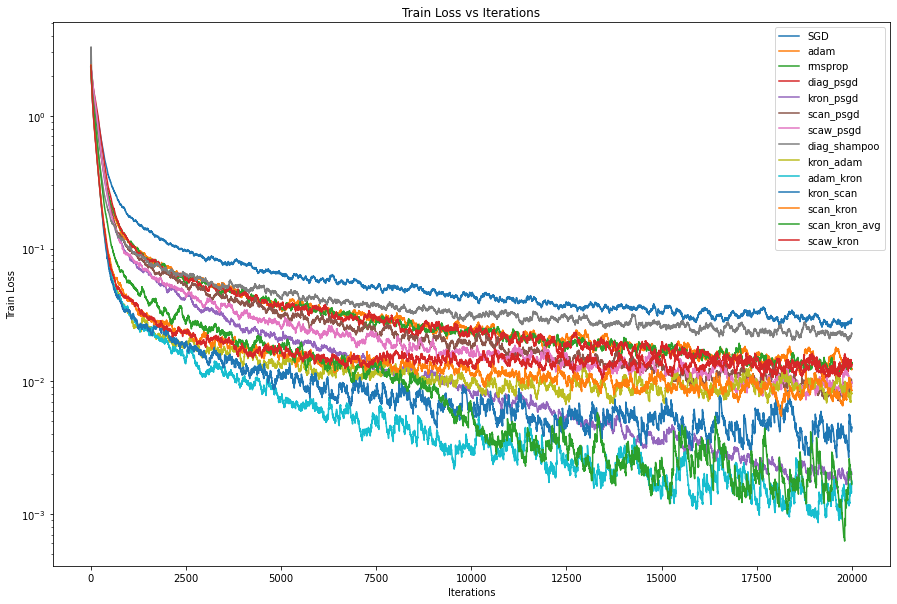

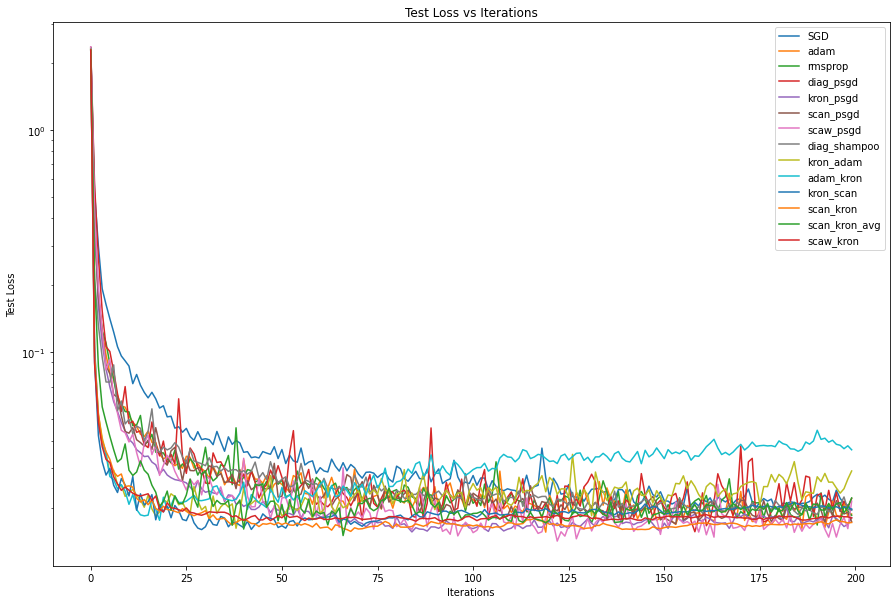

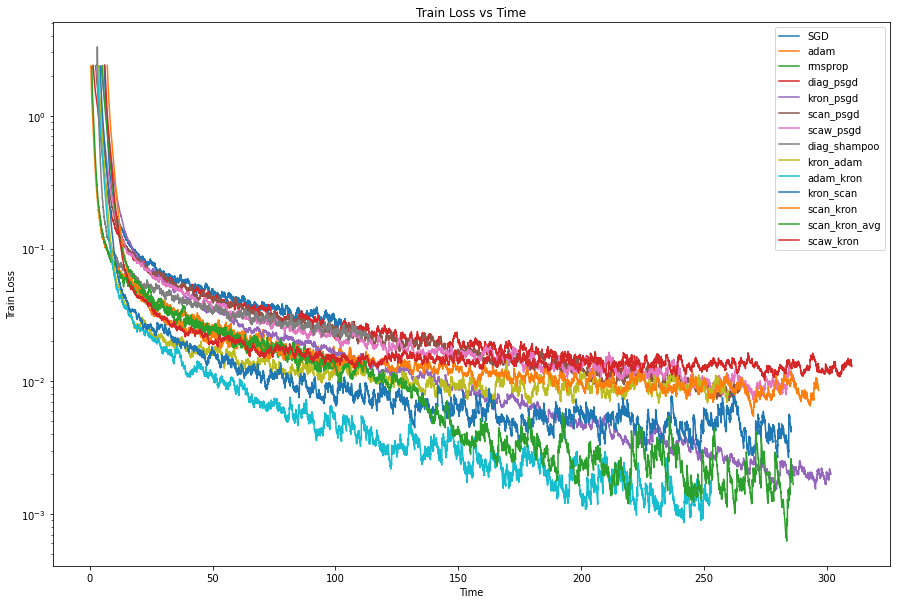

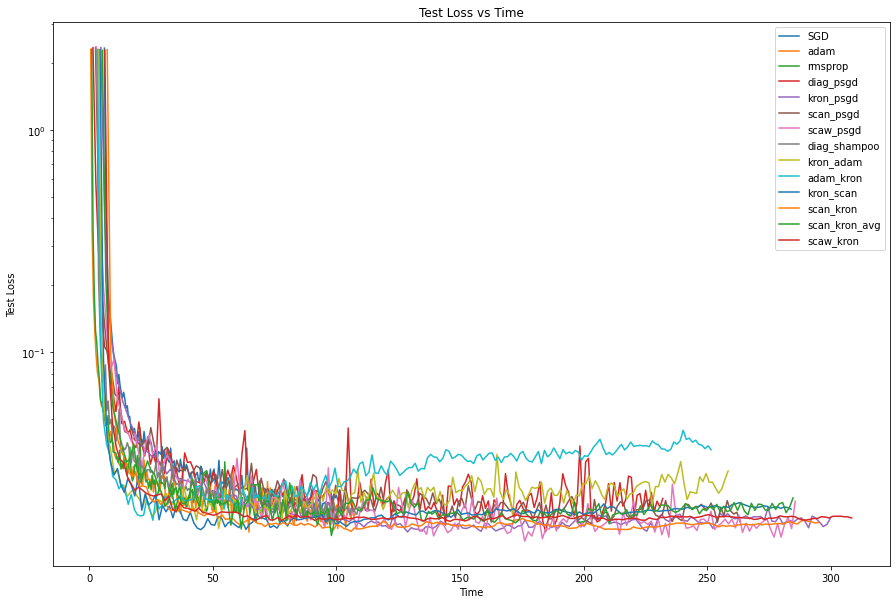

In [0]:
# plot train_losses vs Iterations
plot_metrics(None,train_losses,'Train Loss vs Iterations', 'Iterations','Train Loss')
# plot test_losses vs Iterations
plot_metrics(None,test_losses,'Test Loss vs Iterations', 'Iterations','Test Loss')
# # plot test_losses vs Iterations
plot_metrics(train_times,train_losses,'Train Loss vs Time', 'Time','Train Loss')
# plot test_losses vs Iterations
plot_metrics(test_times,test_losses,'Test Loss vs Time', 'Time','Test Loss')

In [0]:
def plot_acc_metrics(xaxis,yaxis,title, x_label,y_label):
  fig = plt.figure(figsize=(15,10))
  if(xaxis != None):
    for opt in opts:
      plt.plot(xaxis[opt],yaxis[opt])
  else:
    for opt in opts:
      plt.plot(yaxis[opt])
      
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend(opts)
  plt.ylim(0.95,1)

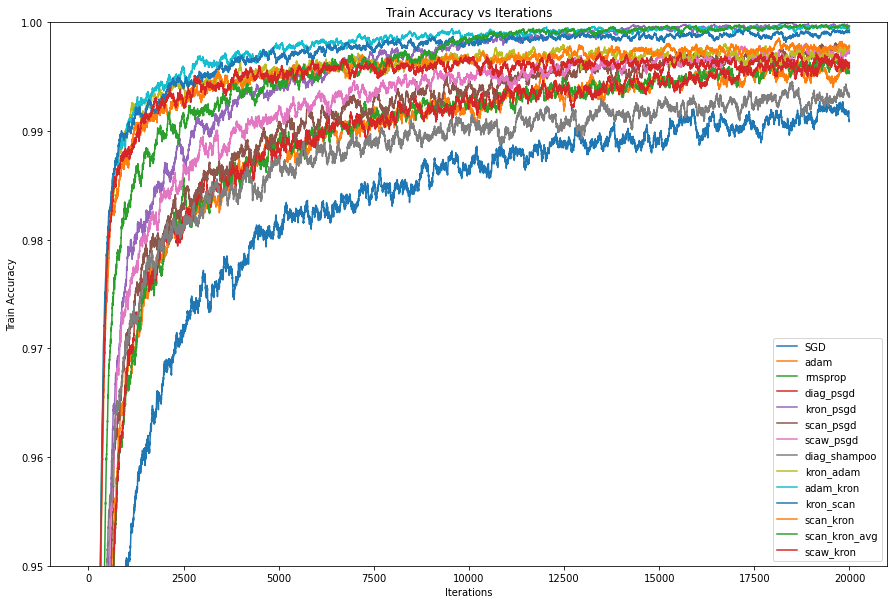

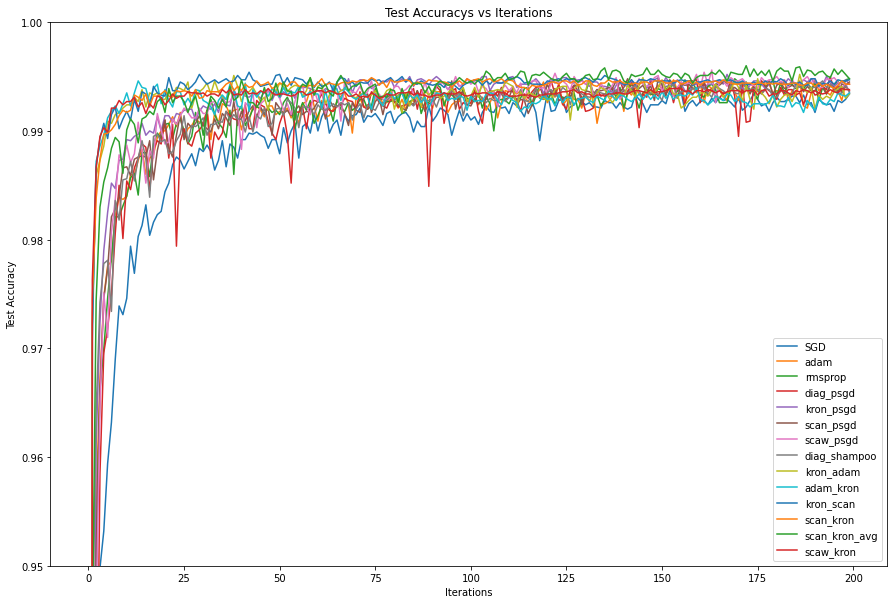

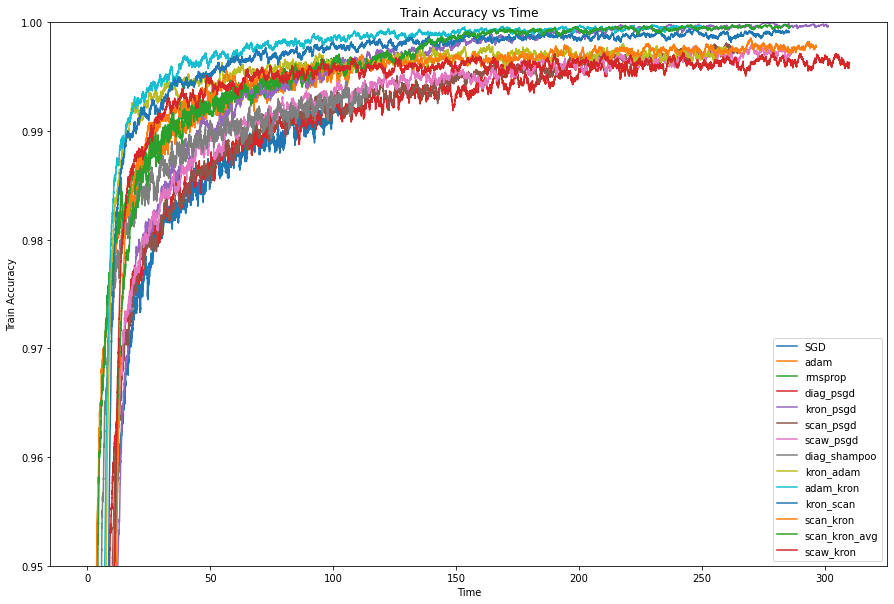

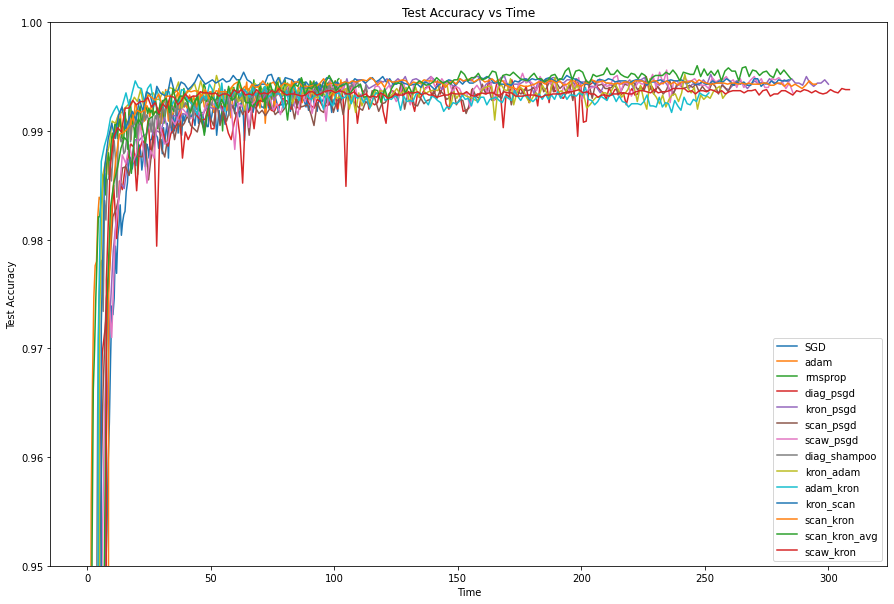

In [0]:
# plot train_losses vs Iterations
plot_acc_metrics(None,train_accs,'Train Accuracy vs Iterations', 'Iterations','Train Accuracy')
# plot test_losses vs Iterations
plot_acc_metrics(None,test_accs,'Test Accuracys vs Iterations', 'Iterations','Test Accuracy')
# # plot test_losses vs Iterations
plot_acc_metrics(train_times,train_accs,'Train Accuracy vs Time', 'Time','Train Accuracy')
# plot test_losses vs Iterations
plot_acc_metrics(test_times,test_accs,'Test Accuracy vs Time', 'Time','Test Accuracy')

In [0]:
 print(tabulate(zip([(k) for k,v in total_train_time.items()],
                   [v for k,v in total_train_time.items()],
                   [v/ITERATIONS for k,v in total_train_time.items()]),headers = ['optimizers','total time (sec)','time per iteration']))

optimizers       total time (sec)    time per iteration
-------------  ------------------  --------------------
SGD                       103.819            0.00519093
adam                      108.049            0.00540243
rmsprop                   102.366            0.00511832
diag_psgd                 233.222            0.0116611
kron_psgd                 301.501            0.0150751
scan_psgd                 264.69             0.0132345
scaw_psgd                 287.092            0.0143546
diag_shampoo              113.914            0.0056957
kron_adam                 259.81             0.0129905
adam_kron                 252.896            0.0126448
kron_scan                 285.444            0.0142722
scan_kron                 284.288            0.0142144
scan_kron_avg             286.197            0.0143099


**A. Loss vs Epochs**


1.   Training:  ADAM_KRON is best. Though At the start, all combinations converge better than simple KRONECKER preconditioner. But later, above mentioned seems to work best while SCAN_KRON and KRON_ADAM seems to work worst. 
Although KRON_SCAN works comparable even in latter stages. Not too bad 
2.   Testing: SCAN_KRON_AVG, ADAM_KRON which work best in training start to overfit. KRON_SCAN is the best one. And SCAN_KRON works comparable to it

SCAN.KRON and its sqrt doesn't seem to work
**B. Accuracy vs Epochs**
KRON_SCAN is best in testing and training. ADAM_KRON overfits though good in training

CONCLUSION: KRON_SCAN is the winner


# NGROK LAUNCH TENSORBOARD

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [0]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"